In [1]:
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from helpers import train, evaluation, generate_confusion_matrix
from helpers import plot_accuracy, plot_loss, plot_confusion_matrix

In [2]:
DATA_PATH = './15SceneData/'
MODELS_PATH = './models/'
PLOTS_PATH = './plots/'
MODEL_NAME = 'efficientnetb0_pretrianed_fe_freeze'

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

NUM_CLASSES = 15
BATCH_SIZE = 32
NUM_EPOCHS = 100
PATIENCE = 30

# Load Data

In [3]:
# Load the dataset
# Here I added some data augmentation - random resized crop
# I used the mean and std calculated from imagenet dataset as while using pretrained models thats the values that should be used
train_dataset = datasets.ImageFolder(DATA_PATH + 'train',
                                     transform=transforms.Compose([
                                         transforms.Resize((224, 224)),
                                         transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])
                                     ]))

val_dataset = datasets.ImageFolder(DATA_PATH + 'validation',
                                   transform=transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])
                                   ]))

# Create data loaders

In [4]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Load pretrained model

In [5]:
model = models.efficientnet_b0(weights='IMAGENET1K_V1')

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Trainable params before freezing feature extraction params: {:,}'.format(trainable).replace(',', ' '))

# Freeze the feature parameters
for feature_param in model.features.parameters():
    feature_param.requires_grad = False

# Change the last layer to output 15 classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, NUM_CLASSES, bias=True) 
)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Trainable params after freezing feature extraction params: {:,}'.format(trainable).replace(',', ' '))

print(model.classifier)

Trainable params before freezing feature extraction params: 5 288 548
Trainable params after freezing feature extraction params: 19 215
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=15, bias=True)
)


In [6]:
# Train the model
# For the purpose of regularization I used weight decay in the optimizer as well as lr_scheduler
# Lr_scheduler reduces the learning rate when the validation loss plateaus
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

model.to(DEVICE)

fitted, train_loss, train_acc, val_loss, val_acc = train(
    model, 
    optimizer,
    loss_fn,
    train_loader, 
    val_loader, 
    lr_scheduler=lr_scheduler,
    num_epochs=NUM_EPOCHS, 
    patience=PATIENCE, 
    device=DEVICE
    )

torch.save(fitted, MODELS_PATH + MODEL_NAME + '.pt')

Epoch [49/100]: 100%|██████████| 47/47 [00:12<00:00,  3.66it/s, train_acc=89.6, train_loss=0.324, val_acc=86.5, val_loss=0.383]


Epoch 00049: reducing learning rate of group 0 to 1.0000e-04.


Epoch [78/100]: 100%|██████████| 47/47 [00:10<00:00,  4.69it/s, train_acc=90.4, train_loss=0.303, val_acc=86.5, val_loss=0.381]


Epoch 00078: reducing learning rate of group 0 to 1.0000e-05.


Epoch [100/100]: 100%|██████████| 47/47 [00:08<00:00,  5.51it/s, train_acc=92.4, train_loss=0.258, val_acc=86.2, val_loss=0.378]


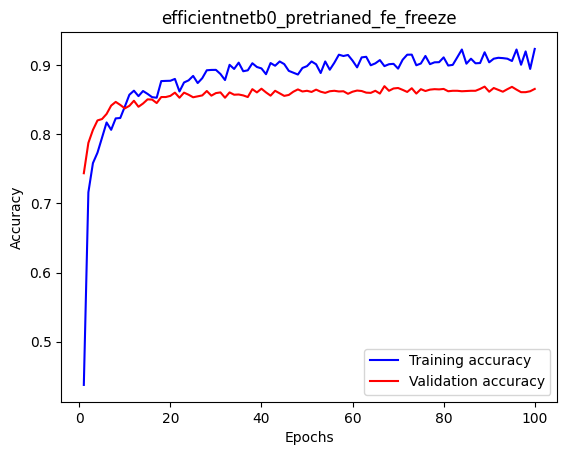

In [7]:
plot_accuracy(train_acc, val_acc, MODEL_NAME, PLOTS_PATH + MODEL_NAME + '_accuracy.png')

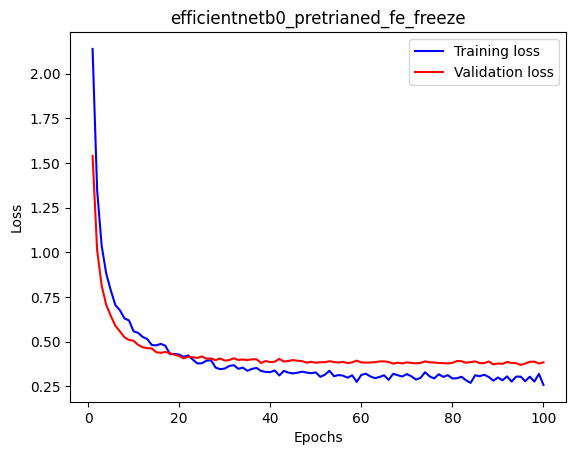

In [8]:
plot_loss(train_loss, val_loss, MODEL_NAME, PLOTS_PATH + MODEL_NAME + '_loss.png')

In [9]:
_, train_accuracy = evaluation(fitted, train_loader, nn.CrossEntropyLoss(), DEVICE)
_, val_accuracy = evaluation(fitted, val_loader, nn.CrossEntropyLoss(), DEVICE)

print(f'Train accuracy: {train_accuracy*100.:.2f}%')
print(f'Validation accuracy: {val_accuracy*100.:.2f}%')

Train accuracy: 95.67%
Validation accuracy: 86.87%


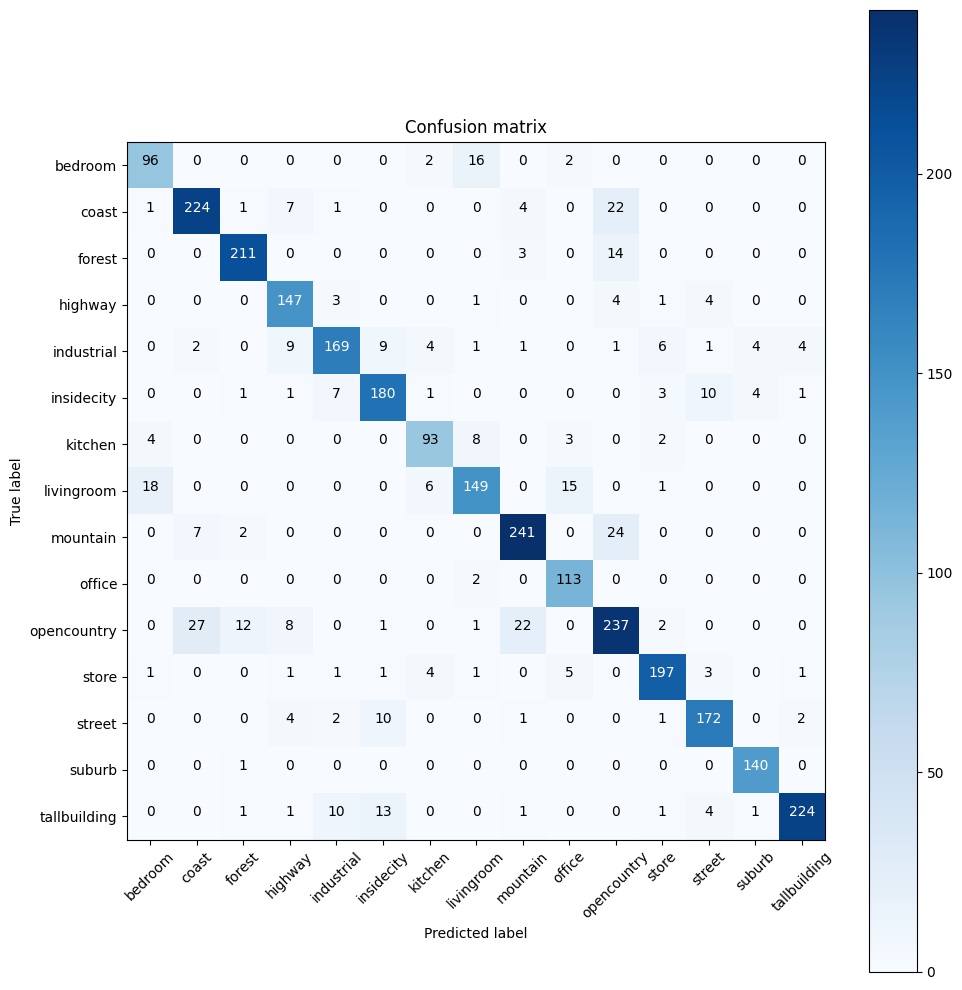

In [10]:
cm = generate_confusion_matrix(fitted, val_loader, DEVICE)

plot_confusion_matrix(
    cm,
    val_loader.dataset.classes,
    'Confusion matrix',
    PLOTS_PATH + MODEL_NAME + '_confusion_matrix.png',
    normalize=False
)